# Canadian Bond Bootstrapping

## Import libraries

In [ ]:
import pandas as pd
from scipy.optimize import fsolve
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

## Read Data

In [73]:
df_dict = {}
def load_data(i):
    df = pd.read_csv(f"Bonds(Jan {i}).csv")
    df.sort_values(by="Maturity Date")
    df["Coupon"] = df["Coupon"].str.rstrip("%").astype('float')
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], format='%m/%d/%Y')
    return df

for i in range(5, 10):
    df_dict[f"jan{i}"] = load_data(i)
for i in range(12, 17):
    df_dict[f"jan{i}"] = load_data(i)

## Calculate YTM

In [75]:
for day in df_dict:
    TODAY = datetime(2026, 1, int(day[3:]))
    for index, row in df_dict[day].iterrows():
        price, coupon, maturity = row["Ask"], row["Coupon"], row["Maturity Date"]
        years_to_maturity = maturity - TODAY
        periods_left = index + 1
        coupon_payment = coupon / 2 
        def bond_price(ytm):
            return coupon_payment * ((1 - (1 + ytm) ** -periods_left) / ytm) + 100 / (1 + ytm) ** periods_left - price
        
        ytm = fsolve(bond_price, 0.02)[0] * 2
        df_dict[day].loc[index, "Calculated YTM"] = ytm

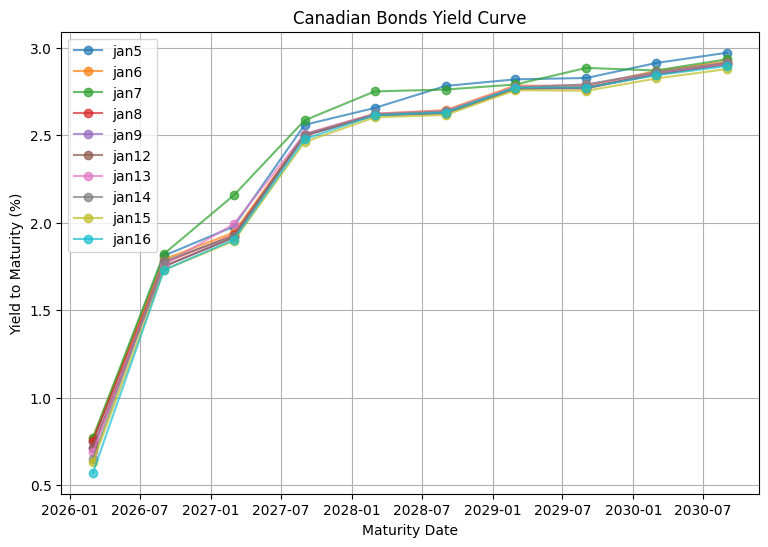

In [197]:
plt.figure(figsize=(9, 6))

for day in df_dict:
    plt.plot(
        df_dict[day]['Maturity Date'],
        df_dict[day]['Calculated YTM'] * 100,
        marker='o',
        linestyle='-',
        alpha = 0.7,
        label=day
    )

plt.xlabel('Maturity Date')
plt.ylabel('Yield to Maturity (%)')
plt.title('Canadian Bonds Yield Curve')
plt.grid(True)
plt.legend()
plt.show()

## Derive Spot Curve

In [98]:
for day in df_dict:
    TODAY = datetime(2026, 1, int(day[3:]))

    t, spot_rates = [],[]

    for i, row, in df_dict[day].iterrows():
        price, coupon, maturity = row["Ask"], row["Coupon"], row["Maturity Date"]
        coupon_payment = coupon / 2
        t.append((df_dict[day].loc[i, "Maturity Date"] - TODAY).days/365)
        for j in range(i):
            price -= coupon_payment/(1+spot_rates[j]) ** t[j]
        spot_rates.append(((100+coupon_payment)/price)**(1/t[i]) - 1)

    df_dict[day]["Spot Rate"] = spot_rates

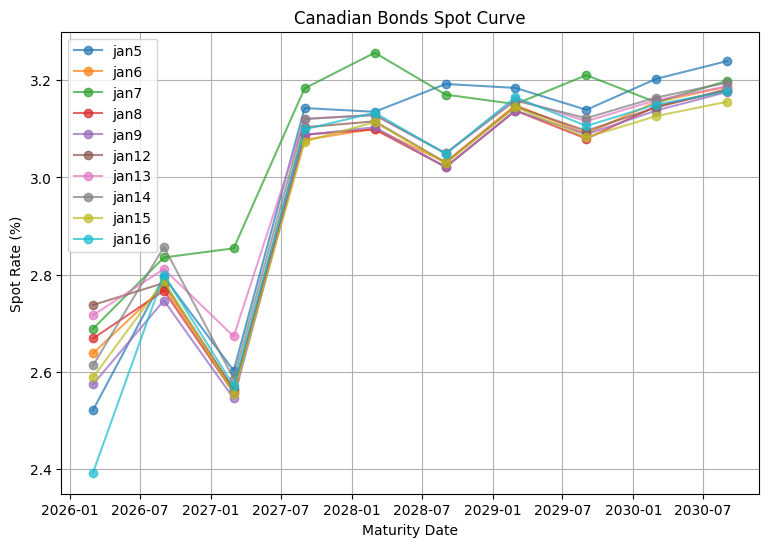

In [199]:
plt.figure(figsize=(9, 6))

for day in df_dict:
    plt.plot(
        df_dict[day]['Maturity Date'],
        df_dict[day]['Spot Rate'] * 100,
        marker='o',
        linestyle='-',
        alpha = 0.7,
        label=day
    )

plt.xlabel('Maturity Date')
plt.ylabel('Spot Rate (%)')
plt.title('Canadian Bonds Spot Curve')
plt.grid(True)
plt.legend()
plt.show()

## Derive Forward Curve

In [117]:
forward_dict = {}
for day in df_dict:
    TODAY = datetime(2026, 1, int(day[3:]))
    forward_rates = []
    for i in range(2, len(df_dict[day]), 2):
        t = (df_dict[day].loc[i-2, "Maturity Date"] - TODAY).days/365
        n = (df_dict[day].loc[i, "Maturity Date"] - df_dict[day].loc[i-2, "Maturity Date"]).days/365
        s1 = df_dict[day].loc[i-2, "Spot Rate"]
        s2 = df_dict[day].loc[i, "Spot Rate"]
        forward_rates.append(((1+s2)**(t+n) / (1+s1)**t)**(1/n)-1)


    data = {
        "Time": ["1yr-1yr", "1yr-2yr", "1yr-3yr","1yr-4yr"],
        "Forward Rate": forward_rates
    }
    forward_dict[day] = pd.DataFrame(data)

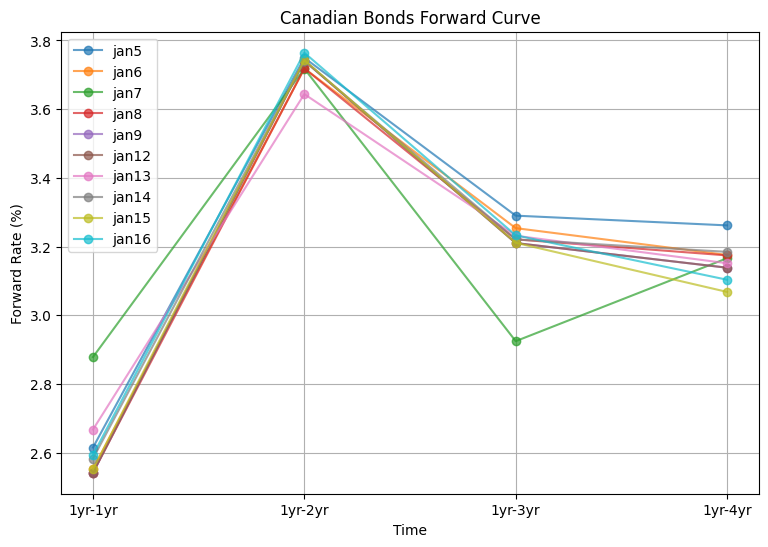

In [201]:
plt.figure(figsize=(9, 6))

for day in df_dict:
    plt.plot(
        forward_dict[day]['Time'],
        forward_dict[day]['Forward Rate'] * 100,
        marker='o',
        linestyle='-',
        alpha = 0.7,
        label=day
    )

plt.xlabel('Time')
plt.ylabel('Forward Rate (%)')
plt.title('Canadian Bonds Forward Curve')
plt.grid(True)
plt.legend()
plt.show()

## Calculate Covariance Matrices

In [169]:
X = []
days = [5,6,7,8,9,12,13,14,15,16]
for bond in range(len(df_dict["jan5"])):
    Xi = []
    for day in range(len(days) - 1):
        Xi.append(np.log(df_dict[f"jan{days[day+1]}"].loc[bond, "Calculated YTM"]/df_dict[f"jan{days[day]}"].loc[bond, "Calculated YTM"]))
    X.append(Xi)

ytm_cov = np.cov(X)

ytm_cov_df = pd.DataFrame(
    ytm_cov
)
print("Covariance Matrix: YTM")
print(ytm_cov_df)

Covariance Matrix: YTM
          0         1         2         3         4         5         6  \
0  0.001434 -0.000033  0.000344 -0.000091  0.000032 -0.000258 -0.000120   
1 -0.000033  0.000266  0.000653  0.000257  0.000311  0.000334  0.000059   
2  0.000344  0.000653  0.003274  0.000963  0.001372  0.001371  0.000192   
3 -0.000091  0.000257  0.000963  0.000352  0.000443  0.000515  0.000084   
4  0.000032  0.000311  0.001372  0.000443  0.000627  0.000646  0.000085   
5 -0.000258  0.000334  0.001371  0.000515  0.000646  0.000832  0.000136   
6 -0.000120  0.000059  0.000192  0.000084  0.000085  0.000136  0.000034   
7 -0.000064  0.000289  0.001134  0.000392  0.000523  0.000569  0.000086   
8 -0.000161  0.000081  0.000147  0.000091  0.000071  0.000137  0.000039   
9 -0.000160  0.000098  0.000222  0.000119  0.000113  0.000180  0.000043   

          7         8         9  
0 -0.000064 -0.000161 -0.000160  
1  0.000289  0.000081  0.000098  
2  0.001134  0.000147  0.000222  
3  0.000392  0.

In [165]:
X = []
days = [5,6,7,8,9,12,13,14,15,16]
for bond in range(len(forward_dict["jan5"])):
    Xi = []
    for day in range(len(days) - 1):
        Xi.append(np.log(forward_dict[f"jan{days[day+1]}"].loc[bond, "Forward Rate"]/forward_dict[f"jan{days[day]}"].loc[bond, "Forward Rate"]))
    X.append(Xi)

forward_cov = np.cov(X)

forward_cov_df = pd.DataFrame(
    forward_cov
)
print("Covariance Matrix: Forward Rate")
print(forward_cov_df)

Covariance Matrix: Forward Rate
          0         1         2         3
0  0.004285 -0.000234 -0.003000  0.000052
1 -0.000234  0.000190 -0.000013  0.000049
2 -0.003000 -0.000013  0.002612  0.000124
3  0.000052  0.000049  0.000124  0.000279


## Eigenvalues and Eigenvectors

In [187]:
ytm_evals, ytm_evecs = np.linalg.eigh(ytm_cov)

idx = np.argsort(ytm_evals)[::-1]
ytm_evals = ytm_evals[idx]
ytm_evecs = ytm_evecs[:, idx]

print("YTM:\n")
print("Eigenvalues")
print(pd.Series(ytm_evals))

print(pd.DataFrame(ytm_evecs, index= [f"Eigenvector {i + 1}" for i in range(10)]))

YTM:

Eigenvalues
0    5.428272e-03
1    1.626063e-03
2    1.737461e-04
3    9.906595e-05
4    5.070639e-05
5    9.003746e-06
6    1.154090e-06
7    8.828978e-07
8    2.684316e-20
9   -2.035807e-20
dtype: float64
                       0         1         2         3         4         5  \
Eigenvector 1  -0.028255  0.931595 -0.287593  0.194207 -0.056702 -0.051167   
Eigenvector 2  -0.170101 -0.053713 -0.651224 -0.535454  0.067908  0.471996   
Eigenvector 3  -0.765483  0.167382  0.459638 -0.254842 -0.289341  0.108789   
Eigenvector 4  -0.243389 -0.094025 -0.263882  0.052841 -0.032991 -0.617200   
Eigenvector 5  -0.333834 -0.012311 -0.015848  0.039490  0.648771 -0.135571   
Eigenvector 6  -0.353696 -0.223941 -0.243432  0.772728 -0.075666  0.387106   
Eigenvector 7  -0.051779 -0.087016 -0.052410  0.023817 -0.336070 -0.002570   
Eigenvector 8  -0.281917 -0.075360 -0.166789 -0.057775  0.303398 -0.259723   
Eigenvector 9  -0.045734 -0.118827 -0.239516 -0.072383 -0.448054 -0.174546   
Eigenve

In [194]:
for_evals, for_evecs = np.linalg.eigh(forward_cov)
idx = np.argsort(for_evals)[::-1]
for_evals = for_evals[idx]
for_evecs = for_evecs[:, idx]

print("Forward Rates:\n")
print("Eigenvalues")
print(pd.Series(for_evals))

print(pd.DataFrame(for_evecs, index= [f"Eigenvector {i + 1}" for i in range(4)]))

Forward Rates:

Eigenvalues
0    0.006568
1    0.000474
2    0.000288
3    0.000036
dtype: float64
                      0         1         2         3
Eigenvector 1 -0.796465  0.486519 -0.086969 -0.348395
Eigenvector 2  0.028078 -0.352051  0.611135 -0.708368
Eigenvector 3  0.604007  0.653704 -0.150138 -0.430472
Eigenvector 4  0.005513  0.460469  0.772275  0.437641
